In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Import necessary libraries
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#            print(os.path.join(dirname, filename))
# os.listdir('/kaggle/input/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-18 05:15:24.511046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 05:15:24.511163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 05:15:24.642737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


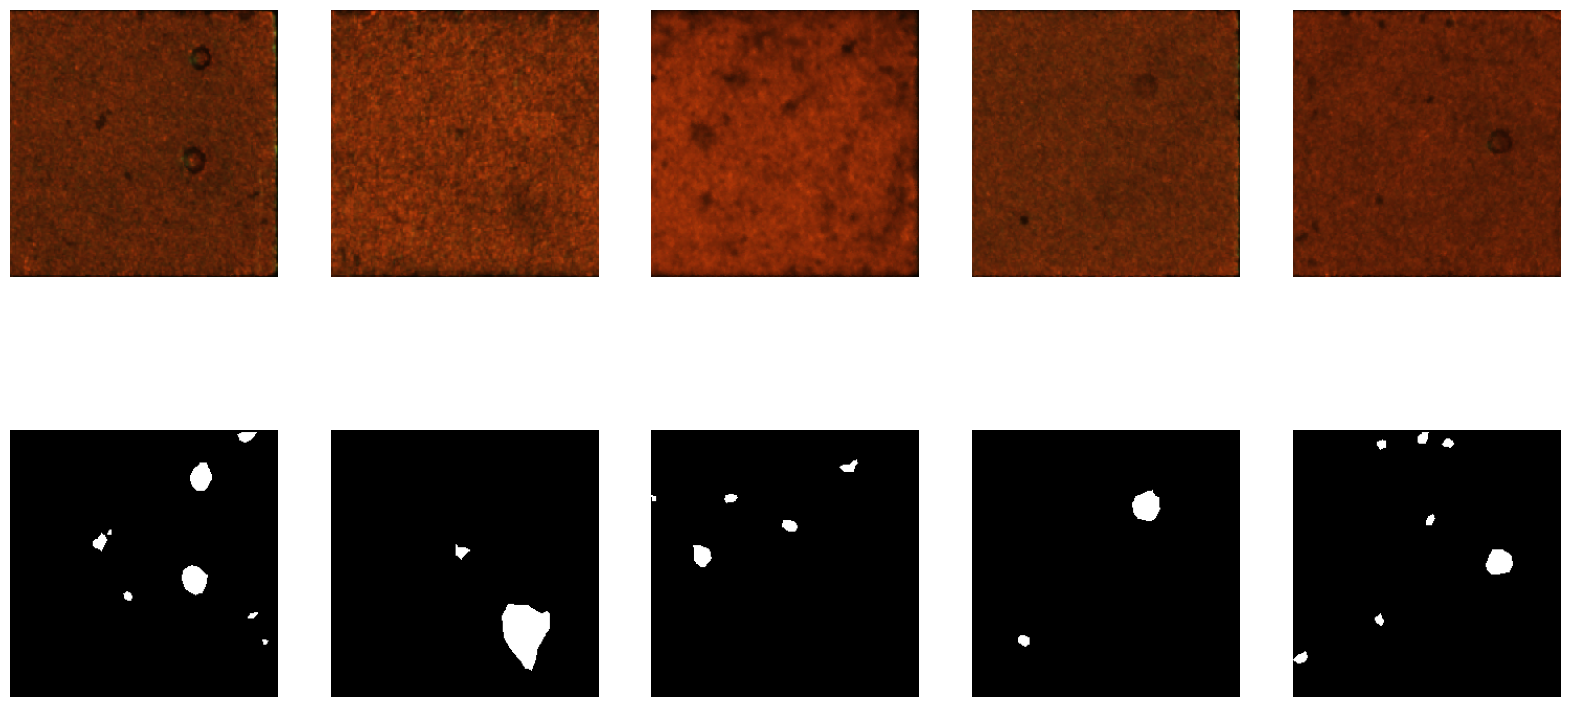

In [ ]:
# Define the path to the data
image_dir = '/kaggle/input/heat-sink-surface-defect-dataset/Heat_Sink_Surface_Defect_Dataset/images'
mask_dir = '/kaggle/input/heat-sink-surface-defect-dataset/Heat_Sink_Surface_Defect_Dataset/labels'

# Function to load images and masks with contrast enhancement
def load_images(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.bmp'):
            img_path = os.path.join(image_dir, img_name)
            mask_name = img_name.replace('.bmp', '.png')
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                img = img_to_array(load_img(img_path, target_size=target_size, color_mode='rgb'))
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, target_size)
                mask = cv2.equalizeHist(mask)
                mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
                images.append(img)
                masks.append(mask)
    return np.array(images), np.array(masks)

images, masks = load_images(image_dir, mask_dir)

# Normalize images
images = images / 255.0
masks = masks / 255.0

# Ensure masks are binary
masks[masks > 0.5] = 1
masks[masks <= 0.5] = 0

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Function to display images and masks
def display_samples(images, masks, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Display samples
display_samples(X_train, y_train)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [ ]:
def segnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up4 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=conv9)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = segnet_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             

 Total params: 11,743,745 (44.80 MB)

 Trainable params: 11,736,065 (44.77 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [ ]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('segnet_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=20,
                    callbacks=callbacks)


Epoch 1/20


2024-06-18 05:17:18.335091: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 05:17:19.532405: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.197532208s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-18 05:17:22.166590: E external/

50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7041 - loss: 0.6725 - val_accuracy: 0.0257 - val_loss: 24.4402
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 667ms/step - accuracy: 0.9690 - loss: 0.4057 - val_accuracy: 0.9753 - val_loss: 0.2639
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 656ms/step - accuracy: 0.9734 - loss: 0.2383 - val_accuracy: 0.3167 - val_loss: 0.6570
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.9746 - loss: 0.1533 - val_accuracy: 0.9753 - val_loss: 0.1292
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 671ms/step - accuracy: 0.9741 - loss: 0.1187 - val_accuracy: 0.9753 - val_loss: 0.1205
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 668ms/step - accuracy: 0.9760 - loss: 0.0979 - val_accuracy: 0.9753 - val_loss: 0.1161
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 660ms/step - accuracy: 0.9737 - loss: 0.0962 - val_accuracy: 0.9753 - val_loss: 0.1165
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 655ms/step - accuracy: 0.9775 - loss: 0.0826 - val_accuracy: 0.9753

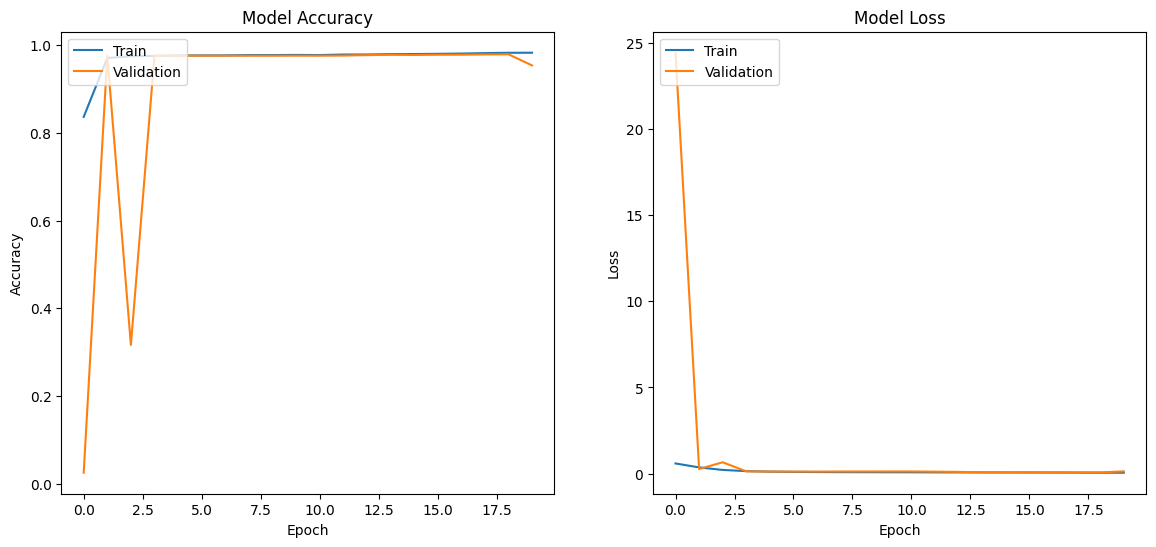

In [ ]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt

# Plotting function for training history
def plot_history(history):
    # Check if history contains accuracy and loss values
    if not ('accuracy' in history.history and 'val_accuracy' in history.history):
        print("Error: The training history does not contain accuracy values.")
        return
    if not ('loss' in history.history and 'val_loss' in history.history):
        print("Error: The training history does not contain loss values.")
        return

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Call the plotting function with the training history
plot_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 530ms/step


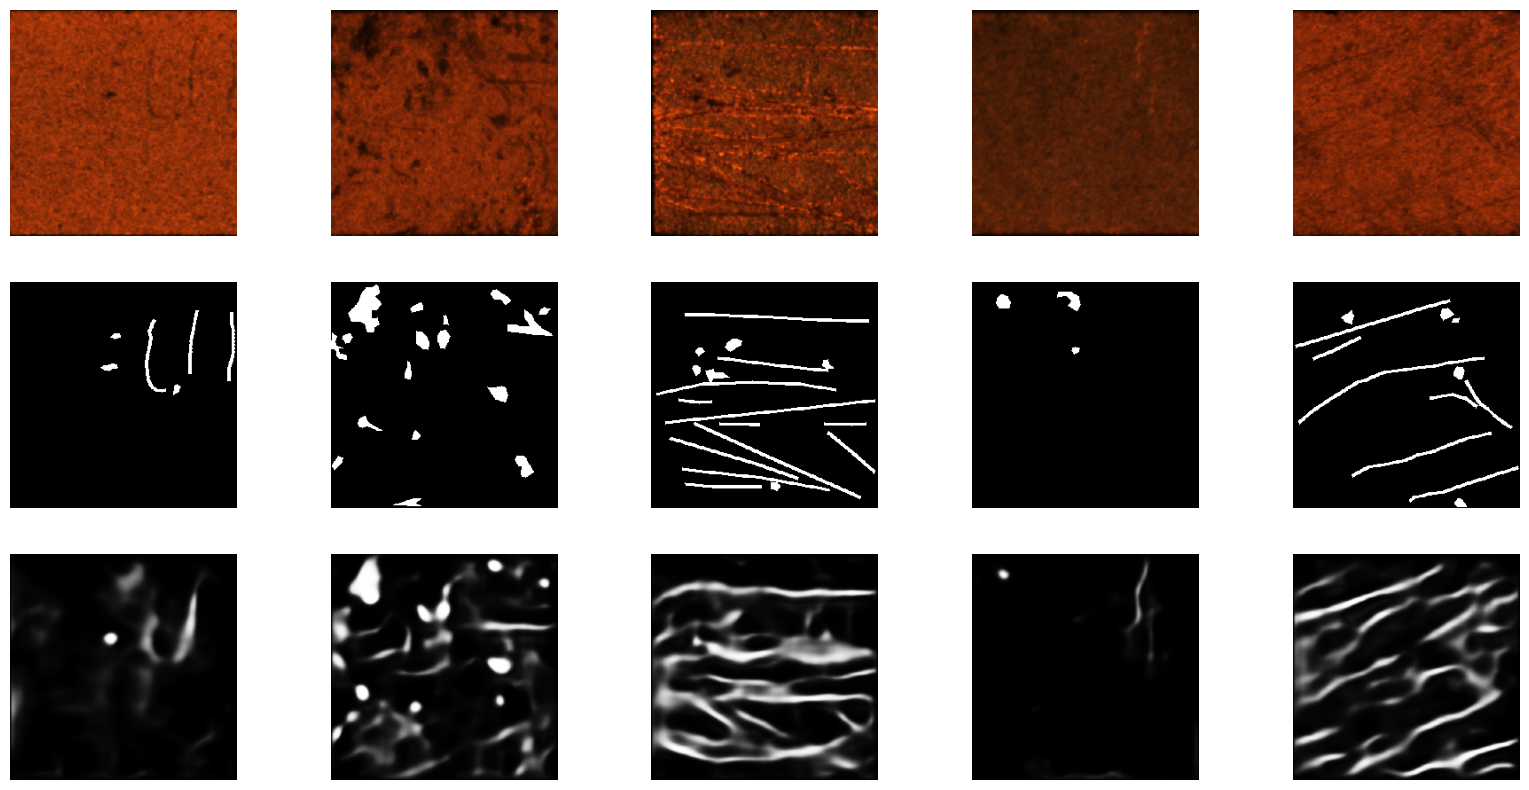

In [ ]:
# Predict on validation set
preds = model.predict(X_val)

# Display some predictions
def display_predictions(images, masks, preds, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

display_predictions(X_val, y_val, preds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step
Measurement Validation Measurement
Accuracy: 0.9532
Precision: 0.2459
Recall: 0.4347
F1 score: 0.3141
IoU: 0.1863


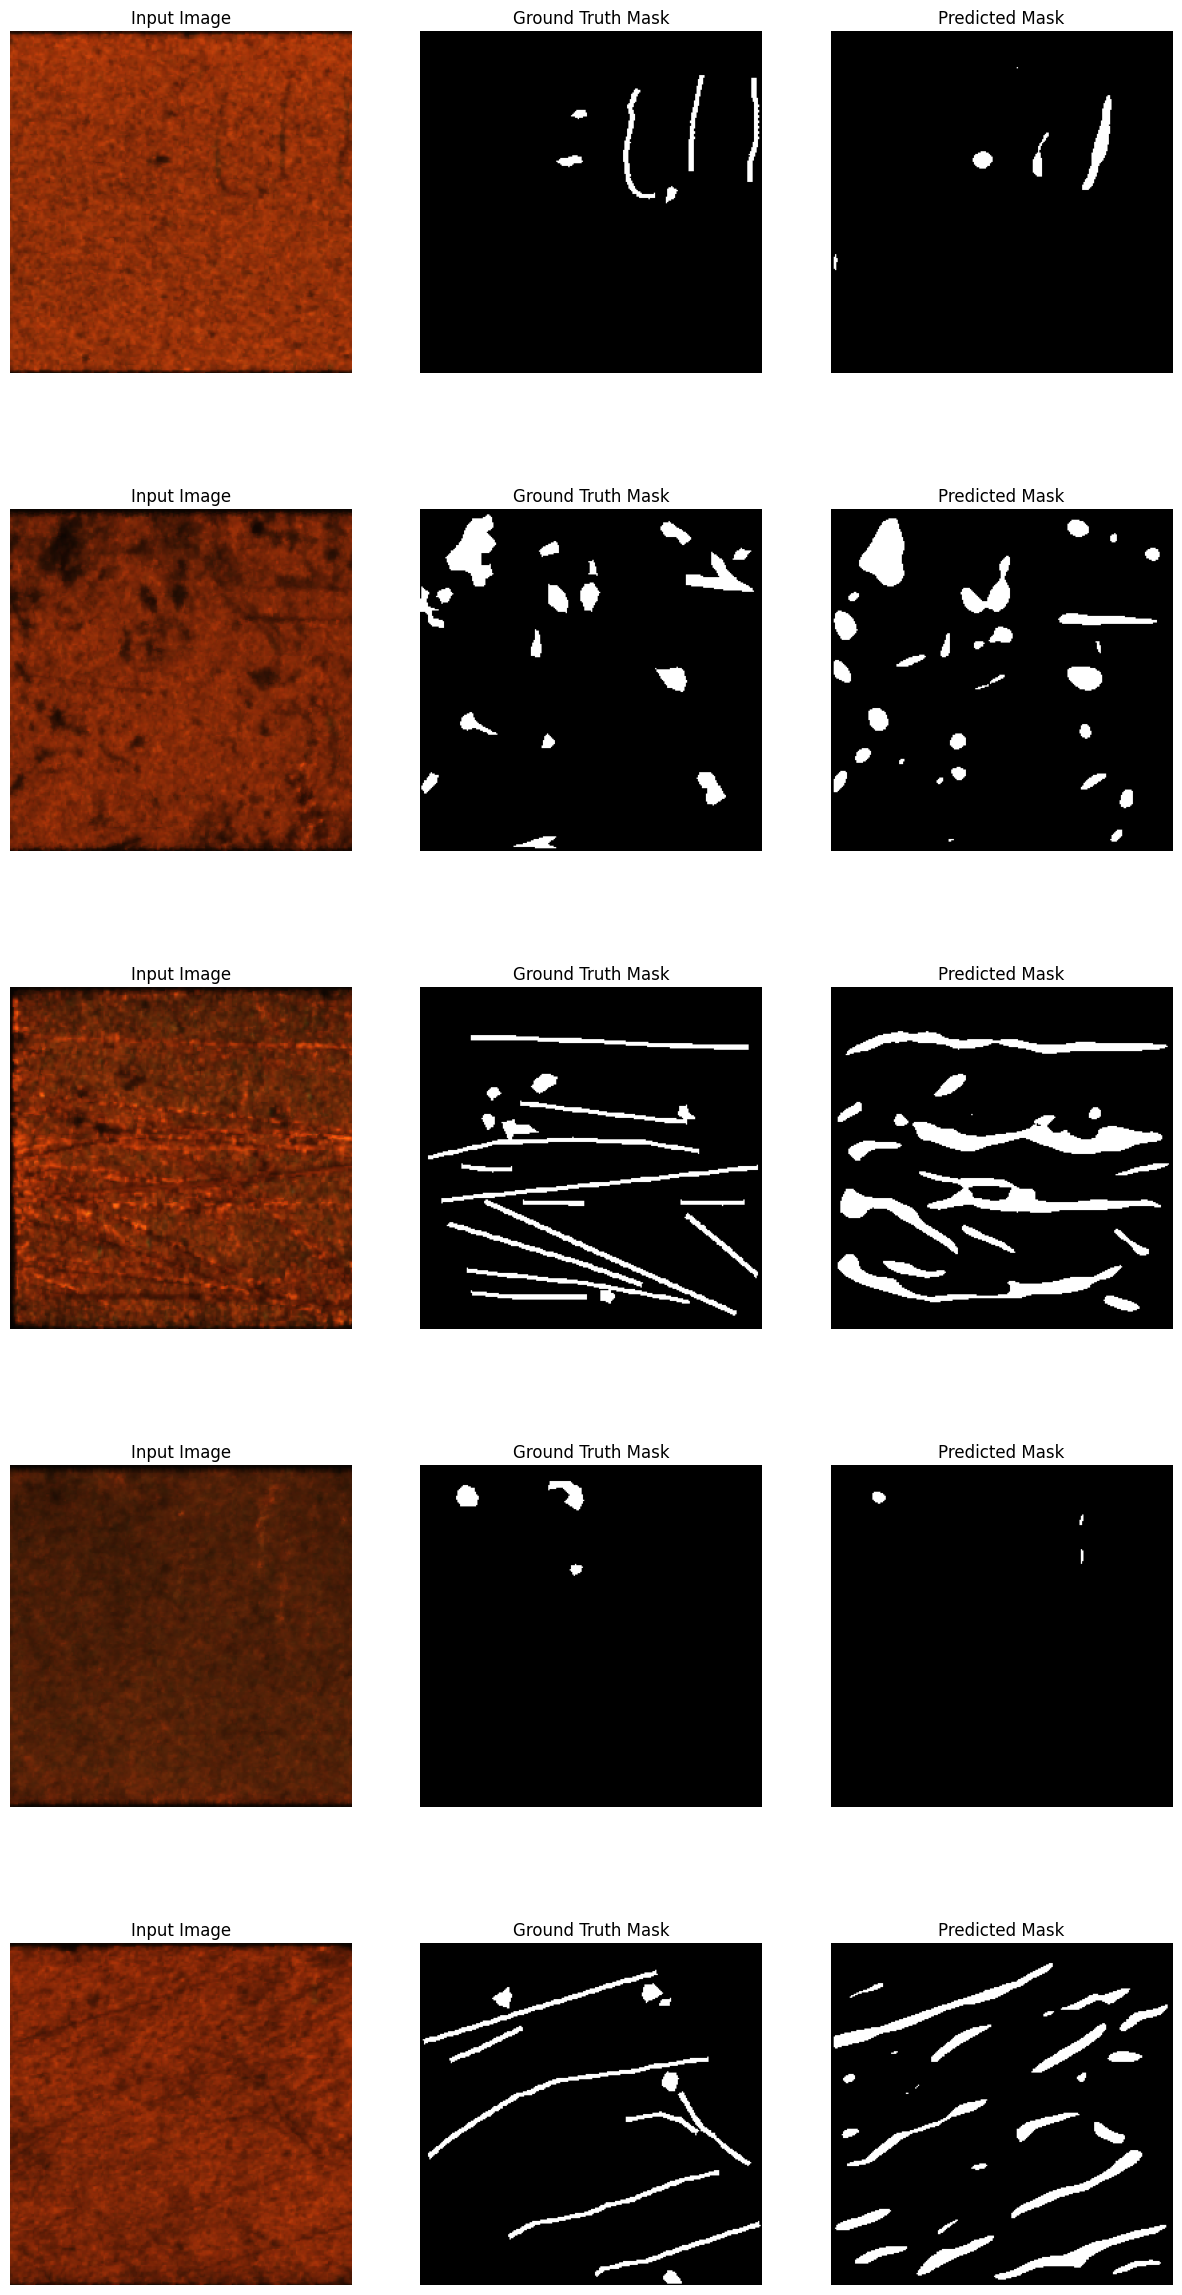

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, jaccard_score
def evaluate(measurement_name, model, X_test, y_test, threshold=0.5):
    # Predict masks
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > threshold).astype(np.uint8)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())
    precision = precision_score(y_test.flatten(), y_pred_binary.flatten())
    recall = recall_score(y_test.flatten(), y_pred_binary.flatten())
    f1 = f1_score(y_test.flatten(), y_pred_binary.flatten())
    iou = jaccard_score(y_test.flatten(), y_pred_binary.flatten())

    print("Measurement " + measurement_name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")

    # Visualize results
    num_images = min(5, len(X_test))
    plt.figure(figsize=(15, 6 * num_images))

    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X_test[i])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(y_pred_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Test the evaluate function with actual model
evaluate("Validation Measurement", model, X_val, y_val)